# BBC News Classification Kaggle Mini-Project

https://www.kaggle.com/c/learn-ai-bbc/overview

## Objectives

This Kaggle competition is about categorizing news articles. You will use matrix factorization to predict the category and submit your notebook for peer evaluation. The goal will be to build a system that can accurately classify previously unseen news articles into the right category.

The competition is evaluated using Accuracy as a metric.

### Description

Text documents are one of the richest sources of data for businesses. We’ll use a public dataset from the BBC comprised of 2225 articles, each labeled under one of 5 categories: business, entertainment, politics, sport or tech.

Following blog has good information on how to look at the problem. https://cloud.google.com/blog/products/gcp/problem-solving-with-ml-automatic-document-classification

### Dataset Description

The dataset is broken into 1490 records for training and 735 for testing.

- **BBC News Train.csv** - the training set of 1490 records
- **BBC News Test.csv** - the test set of 736 records
- **BBC News Sample Solution.csv** - a sample submission file in the correct format
_fields_
- **ArticleId** - Article id unique # given to the record
- **Article** - text of the header and article
- **Category** - cateogry of the article (tech, business, sport, entertainment, politics

## Project Setup

In [16]:
# System stuff
import os
import sys
from pathlib import Path

# Basic data science
import random
import numpy as np
import pandas as pd
import math
import statsmodels.api as sm

import kagglehub   # need this to download dataset

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.matlib import empty
from datetime import datetime
%matplotlib inline

# Scikit-learn (including 3 or 4 that I didn't end up keeping in the final code.
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from wordcloud import WordCloud
from sklearn.decomposition import NMF
from sklearn.pipeline import Pipeline

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC, SVR
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.calibration import CalibratedClassifierCV
from sklearn.inspection import permutation_importance
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve,
    RocCurveDisplay, PrecisionRecallDisplay, ConfusionMatrixDisplay,
    mean_squared_error, mean_absolute_error, r2_score,
    f1_score, accuracy_score, precision_score, recall_score
)

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# Plotting defaults
sns.set_theme(context="notebook", style="darkgrid", palette="deep")
plt.rcParams.update({
    "figure.figsize": (8, 5),
    "figure.dpi": 120,
    "axes.titlesize": 14,
    "axes.labelsize": 12
})
# helper function to delimit sections in data output
def section_split(width=200, char="-"):
    print("\n", char * width, "\n")

# helper function to save figures
def save_figure(name=None, dpi=300, bbox_inches='tight', pad_inches=0.1):
    """
    Save the current matplotlib figure as a PNG file with 300 DPI.
    Returns: str : The full path of the saved file
    """
    # Create directory if it doesn't exist
    save_dir = "figs/5510_mini_project"
    os.makedirs(save_dir, exist_ok=True)

    # Generate filename
    if name is None:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"chart_{timestamp}.png"
    else:
        # Clean the name to be filename-safe
        filename = "".join(c for c in name if c.isalnum() or c in (' ', '-', '_')).rstrip()
        filename = filename.replace(' ', '_')
        if not filename.endswith('.png'):
            filename += '.png'

    # Full path
    filepath = os.path.join(save_dir, filename)

    # Save the figure
    plt.savefig(filepath, dpi=dpi, bbox_inches=bbox_inches, pad_inches=pad_inches)

    print(f"Figure saved: {filepath}")
    return filepath

print("Python:", sys.version.split()[0])
print("Pandas:", pd.__version__)

Python: 3.11.13
Pandas: 2.3.2


In [17]:
## Load the csv files downloaded from the Kaggle Competition page via the api.
sample_solution = pd.read_csv('data/learn-ai-bbc/BBC News Sample Solution.csv', sep = ',')
test = pd.read_csv('data/learn-ai-bbc/BBC News Test.csv', sep = ',')
train = pd.read_csv('data/learn-ai-bbc/BBC News Train.csv', sep = ',')
display(train)

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business
...,...,...,...
1485,857,double eviction from big brother model caprice...,entertainment
1486,325,dj double act revamp chart show dj duo jk and ...,entertainment
1487,1590,weak dollar hits reuters revenues at media gro...,business
1488,1587,apple ipod family expands market apple has exp...,tech


## Exploratory Data Analysis
Note: I will start with the initial analyses provided in the referenced article: Problem-solving with ML: automatic document classification (see above).
- Basic distribution across classes/categories
- tf-idf and use of chi-squared to find unigrams/bigrams
- t-SNE (a dimensionality reduction technique) to plot initial clusters

Just these analyses show us that we have a balanced training dataset, the words and bigrams that correlate best with the categories make sense and the resulting clusters of documents by category are well separated with few outliers.

In [18]:
# Absolute basic checks
print(f'train shape: {train.shape}, test shape: {test.shape}')
print(f'train columns: {train.columns}')
print(f'test columns: {test.columns}')
section_split(width=100)
print(f'Check for duplicates:\n{train.duplicated().sum()}')
print(f'Check for NaNs:\n{train.isna().sum()}\nCheck for nulls:\n{train.isnull().sum()}')

train shape: (1490, 3), test shape: (735, 2)
train columns: Index(['ArticleId', 'Text', 'Category'], dtype='object')
test columns: Index(['ArticleId', 'Text'], dtype='object')

 ---------------------------------------------------------------------------------------------------- 

Check for duplicates:
0
Check for NaNs:
ArticleId    0
Text         0
Category     0
dtype: int64
Check for nulls:
ArticleId    0
Text         0
Category     0
dtype: int64


In [19]:
# first add a CategoryID column to the train set and create dictionaries for lookup
category_ids = train.Category.factorize()
train['CategoryID'] = category_ids[0]
category_to_id = {}
id_to_category = {}
for i, category in enumerate(category_ids[1]):
    category_to_id[category] = i
    id_to_category[i] = category

Figure saved: figs/5510_mini_project/articles_by_category.png


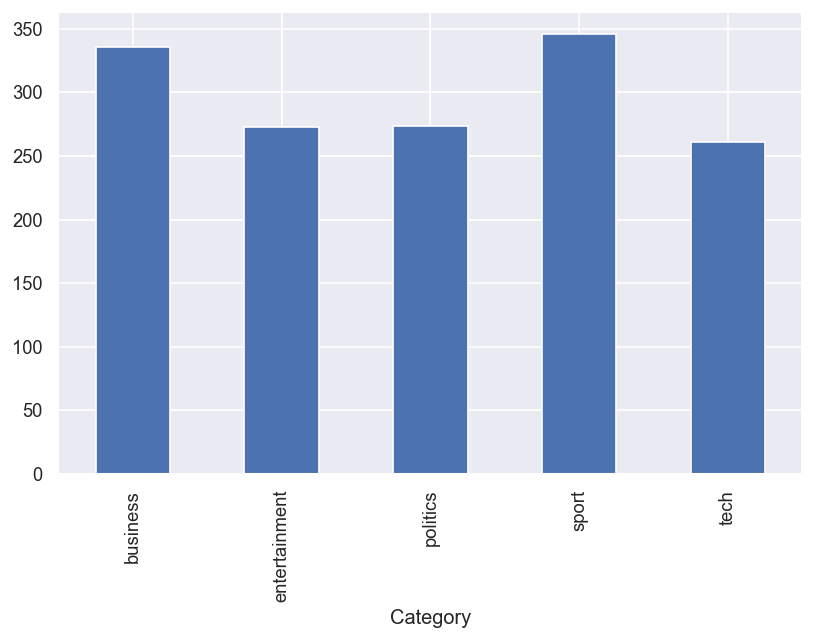

In [20]:
# Check distribution of articles by category
train.groupby('Category').ArticleId.count().plot.bar(ylim=0)
save_figure("articles_by_category")
plt.show()

In [21]:
tfidf = TfidfVectorizer(sublinear_tf=True,
                        min_df=5,
                        norm='l2',
                        encoding='latin-1',
                        ngram_range=(1, 2),
                        stop_words='english')

features = tfidf.fit_transform(train['Text'])
feature_names = tfidf.get_feature_names_out()
labels = train.CategoryID
print(f'After tf-idf vectorisation we have a matrix of (articles, features) {features.shape}')
print(f"Feature names length: {len(feature_names)}")

test_features = tfidf.transform(test['Text']).toarray()

# As the provided test set has no category labels, we need to split the training set further to understand the results of our models better.
# % of the training set for testing.
test_size = 0.3
# We need the indices of the training and test sets to use them later when plotting the results.
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features,
                                                                                 labels,
                                                                                 train.index,
                                                                                 test_size=test_size,
                                                                                 random_state=SEED)

After tf-idf vectorisation we have a matrix of (articles, features) (1490, 9927)
Feature names length: 9927


In [22]:
N = 3 # num unigrams/bigrams to show per category
for category, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  names_array = np.array(feature_names)[indices]
  unigrams = [v for v in names_array if len(v.split(' ')) == 1]
  bigrams = [v for v in names_array if len(v.split(' ')) == 2]
  print("# '{}':".format(category))
  print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))

# 'business':
  . Most correlated unigrams:
       . growth
       . bank
       . shares
  . Most correlated bigrams:
       . stock market
       . economic growth
       . analysts said
# 'entertainment':
  . Most correlated unigrams:
       . singer
       . actor
       . film
  . Most correlated bigrams:
       . won best
       . los angeles
       . box office
# 'politics':
  . Most correlated unigrams:
       . blair
       . election
       . labour
  . Most correlated bigrams:
       . prime minister
       . tony blair
       . mr blair
# 'sport':
  . Most correlated unigrams:
       . match
       . coach
       . cup
  . Most correlated bigrams:
       . grand slam
       . champions league
       . australian open
# 'tech':
  . Most correlated unigrams:
       . technology
       . software
       . users
  . Most correlated bigrams:
       . anti virus
       . mobile phones
       . mobile phone


Figure saved: figs/5510_mini_project/tfidf_feature_vectors.png


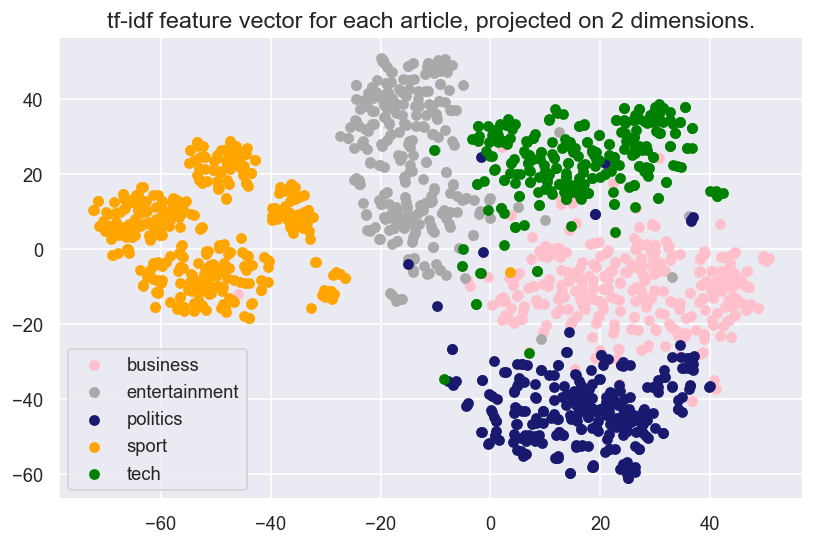

In [23]:
# use t-SNE to plot the tf-idf feature vectors for each article
# Allow sampling a subset of our dataset because t-SNE is computationally expensive
# for now sample = 100% of dataset
f_array = features.toarray()
num_features = len(f_array)
SAMPLE_SIZE = int(num_features * 1)
indices = np.random.choice(range(num_features), size=SAMPLE_SIZE, replace=False)
projected_features = TSNE(n_components=2, random_state=SEED).fit_transform(f_array[indices])
colors = ['pink', 'green', 'midnightblue', 'orange', 'darkgrey']
for category, category_id in sorted(category_to_id.items()):
    points = projected_features[(labels[indices] == category_id).values]
    plt.scatter(points[:, 0], points[:, 1], s=30, c=colors[category_id], label=category)
plt.title("tf-idf feature vector for each article, projected on 2 dimensions.")
plt.legend()
save_figure("tfidf_feature_vectors")
plt.show()

Figure saved: figs/5510_mini_project/tfidf_word_clouds_by_category.png


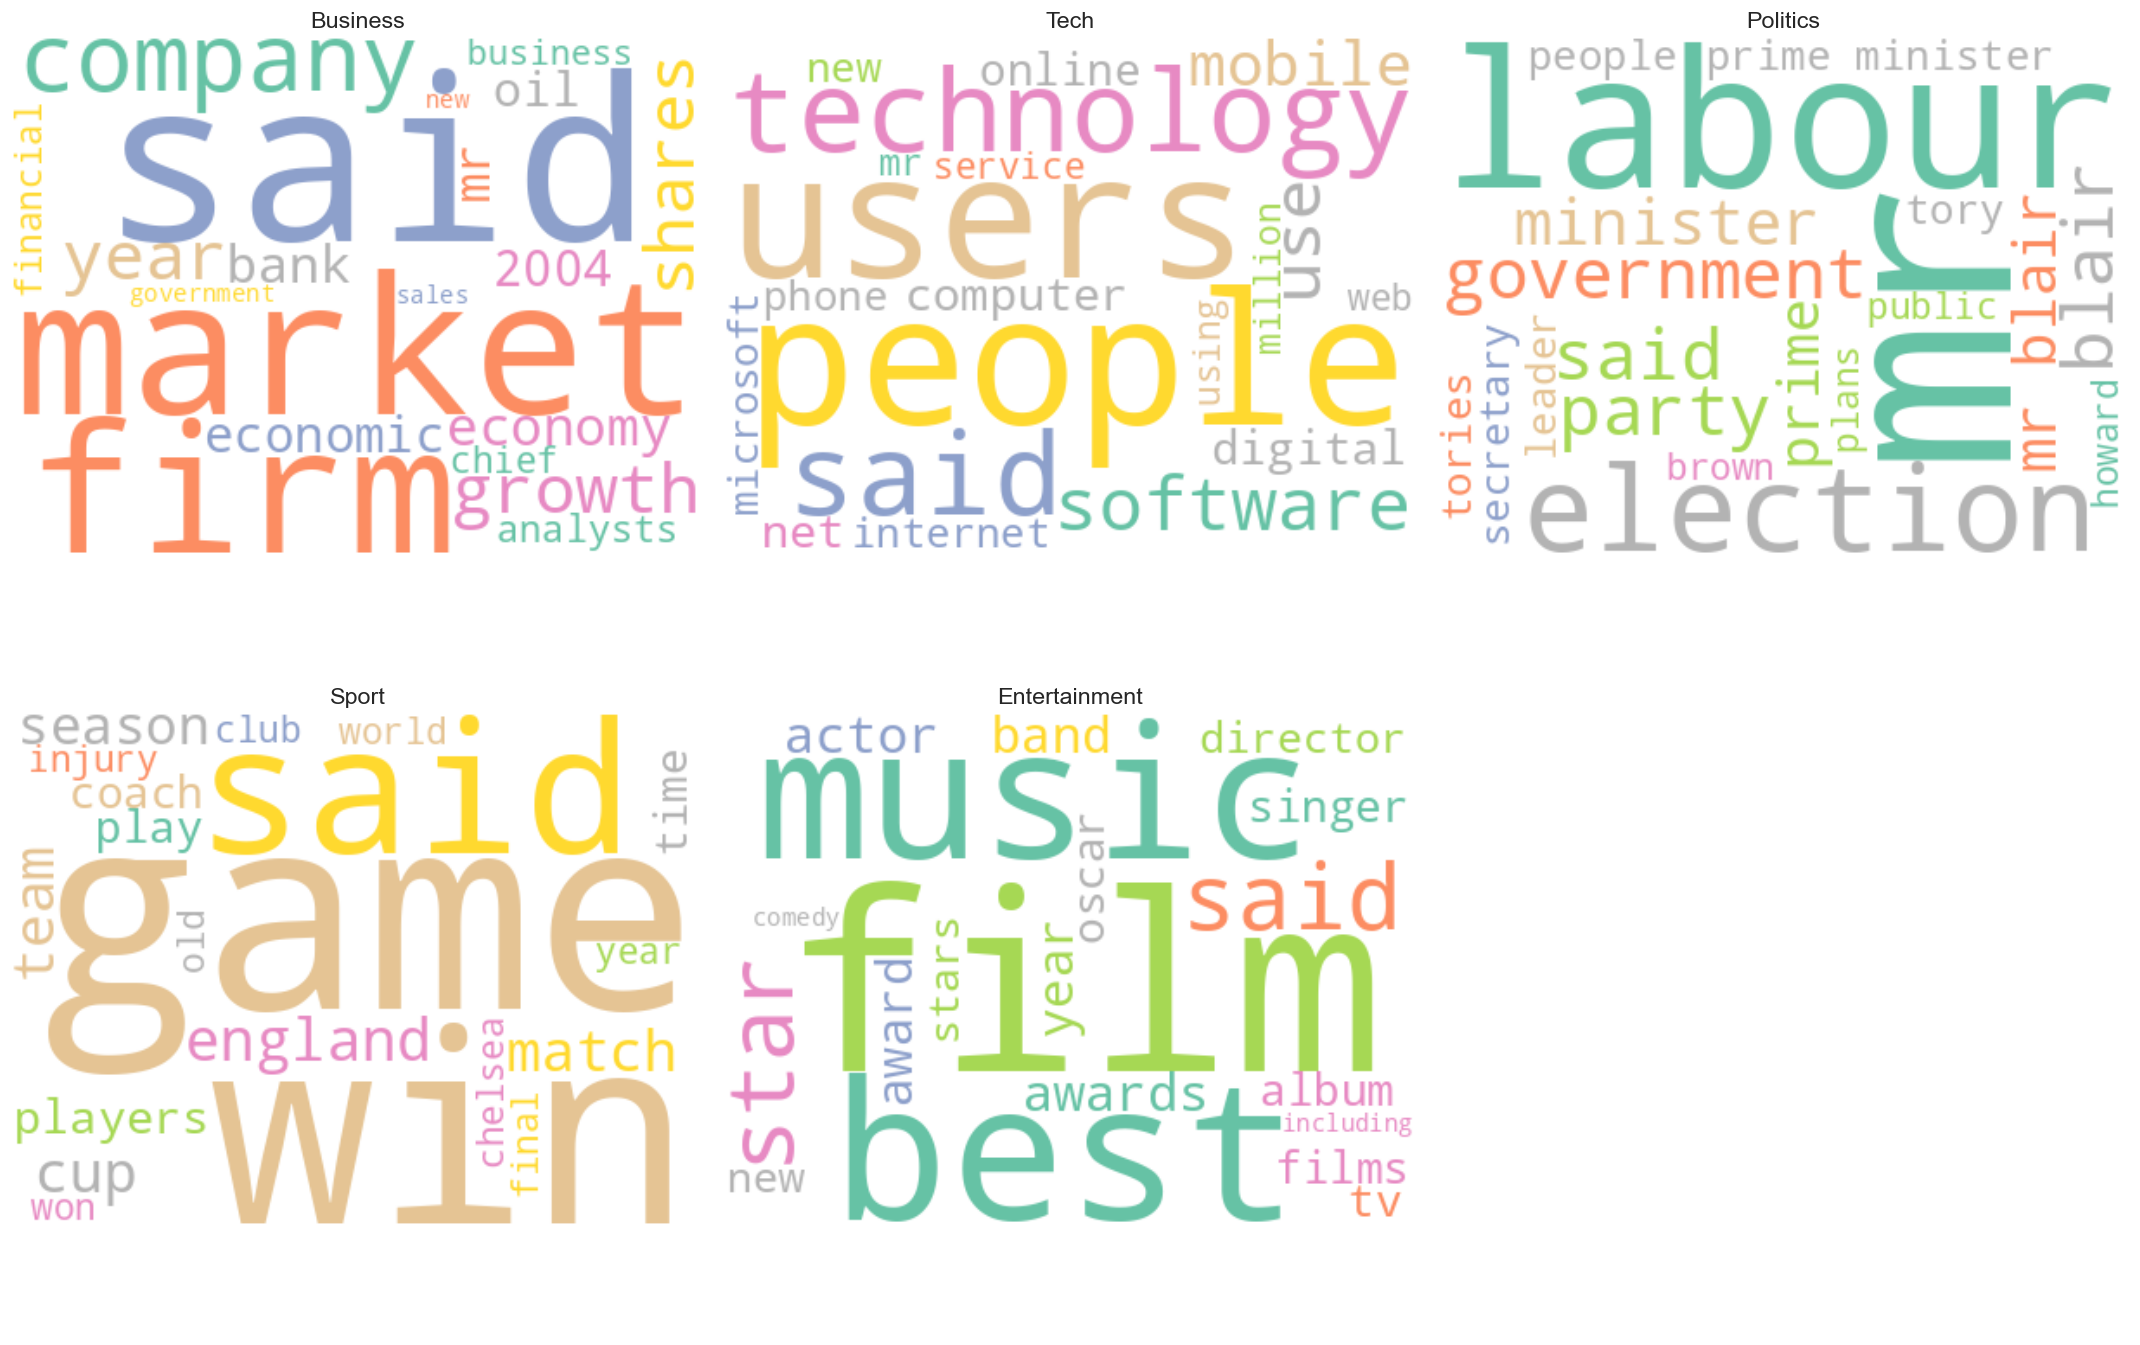

In [24]:
# For fun, let's also look at word clouds for each category
num_words = 20 # how many top words to show per category in the clouds

# Get top TF-IDF words for each category
category_word_scores = {}

for category, category_id in category_to_id.items():
    # Get TF-IDF scores for this category
    category_mask = train['CategoryID'] == category_id
    category_features = features[category_mask]
    # Calculate mean TF-IDF score for each word in this category
    mean_scores = np.array(category_features.mean(axis=0)).flatten()
    # Get top words by TF-IDF score
    top_indices = mean_scores.argsort()[-num_words:][::-1]  # Top num_words in descending order
    top_words_tfidf = []
    for idx in top_indices:
        word = feature_names[idx]
        score = mean_scores[idx]
        top_words_tfidf.append((word, score))
        #print(f"{len(top_words_tfidf):2d}. {word:15s} ({score:.4f})")

    category_word_scores[category] = top_words_tfidf

# Create word clouds from TF-IDF scores
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, (category, word_scores) in enumerate(category_word_scores.items()):
    if i < len(axes):
        # Create word frequency dictionary (use TF-IDF scores as weights)
        word_freq = {word: score*1000 for word, score in word_scores}  # Scale scores

        # Generate word cloud
        wordcloud = WordCloud(
            width=400,
            height=300,
            background_color='white',
            max_words=50,
            colormap='Set2',
            prefer_horizontal=0.7
        ).generate_from_frequencies(word_freq)
        # Plot
        axes[i].imshow(wordcloud, interpolation='bilinear')
        axes[i].set_title(f'{category.capitalize()}')
        axes[i].axis('off')

# Hide unused subplot
if len(category_word_scores) < len(axes):
    axes[-1].axis('off')

plt.tight_layout()
save_figure("tfidf_word_clouds_by_category")
plt.show()

## Supervised Learning Approach

Again, making heavy use of the referenced article, as the objective of this mini-project is to learn about Matrix Factorisation not to optimise supervised learning. In the article, LogisticRegression provided the best accuracy, beating Random Forest Classification and MultinomialNB. I will take that as the starting point.

The LogisticRegression result is a model with high accuracy 97.5%. Examining the miss-classifications from the confusion matrix clarifies the reason for errors. In each example, there are words/bigrams that have high correlation with an alternative category. For example: a business article about mobile phones (2 of the most correlated bigrams with tech).

Validation scores for LogisticRegression
Accuracy: 0.975 +/- 0.002 on entire training set
Figure saved: figs/5510_mini_project/logisticregression_confusion_matrix.png


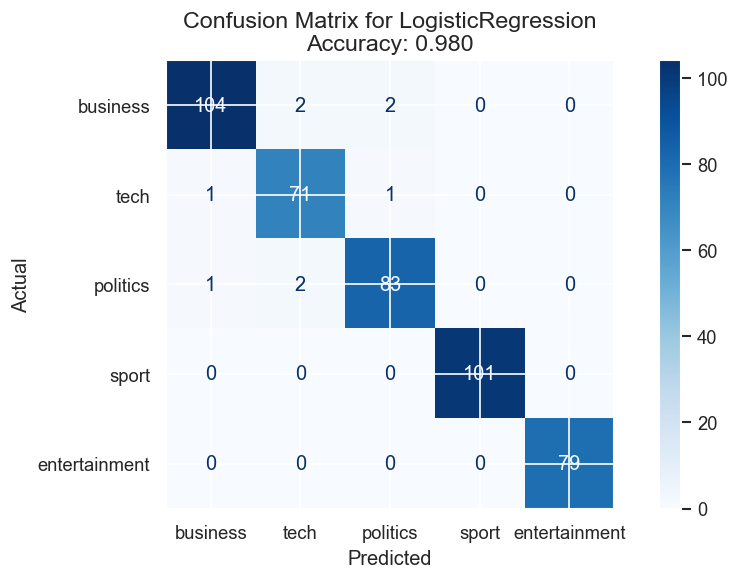


Misclassified articles per category, more than one example:

'business' predicted as 'tech' : 2 examples.

Article 1384 (Category: business):
brussels raps mobile call charges the european commission has written to the mobile phone operators vodafone and t-mobile to challenge  the high rates  they charge for international roaming.  in letters sent to the two companies  the commission alleged the firms were abusing their dominant market po
--------------------------------------------------------------------------------

Article 664 (Category: business):
orange colour clash set for court a row over the colour orange could hit the courts after mobile phone giant orange launched action against a new mobile venture from easyjet s founder.  orange said it was starting proceedings against the easymobile service for trademark infringement. easymobile uses
--------------------------------------------------------------------------------
'politics' predicted as 'tech' : 2 examples.

Article 1415

,ArticleId,Text,Predicted_Category LR
0,1018,qpr keeper day heads for preston queens park r...,sport
1,1319,software watching while you work software that...,tech
2,1138,d arcy injury adds to ireland woe gordon d arc...,sport
3,459,india s reliance family feud heats up the ongo...,business
4,1020,boro suffer morrison injury blow middlesbrough...,sport


In [25]:
cv = 3
scoring = 'accuracy'
LR_model = LogisticRegression(random_state=SEED)
LR_model.fit(features, labels)
accuracies = cross_val_score(LR_model, features, labels, scoring=scoring, cv=cv)
print(f"Validation scores for LogisticRegression\nAccuracy: {accuracies.mean():.3f} +/- {accuracies.std():.3f} on entire training set")

LR_model.fit(X_train, y_train)
y_pred = LR_model.predict(X_test)


def plot_confusion(y_test, y_pred, name='model'):
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=list(id_to_category.values())))
    conf_mat = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    fig_title = f"Confusion Matrix for {name}\nAccuracy: {accuracy:.3f}"
    disp = ConfusionMatrixDisplay(conf_mat, display_labels=list(id_to_category.values()))
    disp.plot(cmap='Blues')
    disp.ax_.set_title(fig_title)
    disp.ax_.set_xlabel("Predicted")
    disp.ax_.set_ylabel("Actual")
    plt.tight_layout()
    save_figure(name.lower()+"_confusion_matrix")
    plt.show()
    print("\nMisclassified articles per category, more than one example:\n")
    for predicted in list(id_to_category.keys()):
        for actual in list(id_to_category.keys()):
            if predicted != actual and conf_mat[actual, predicted] >= 2:
                print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
                mask = (y_test == actual) & (y_pred == predicted)
                misclassified_indices = indices_test[mask]
                for idx in misclassified_indices:
                    print(f"\nArticle {idx} (Category: {train.loc[idx]['Category']}):")
                    print(train.loc[idx]['Text'][:300]
    )
                    print("-" * 80)
    return accuracy

accuracy_logistic_regression = plot_confusion(y_test, y_pred, name='LogisticRegression')

# Predict on the actual test data
test_predictions = LR_model.predict(test_features)
test['Predicted_Category LR'] = [id_to_category[pred] for pred in test_predictions]
print("\nTest predictions:")
display(test.head())


## Next Step - Use Matrix Factorisation to Predict Category
- Approach One = Create a pipeline where NMF (Non-Negative Matrix Factorisation) is used for **dimensionality reduction** then Logistic Regression used as classifier.
- Approach Two = Use NMF for **direct topic extraction**.

Figure saved: figs/5510_mini_project/nmf_one_confusion_matrix.png


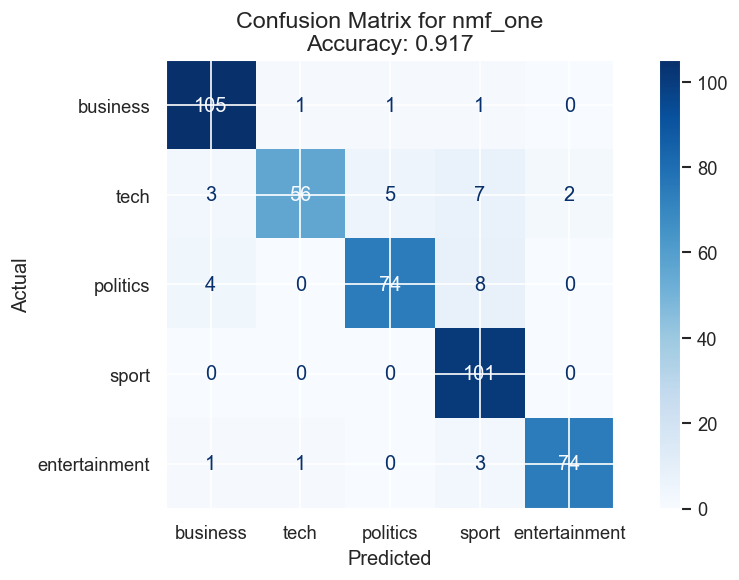


Misclassified articles per category, more than one example:

'tech' predicted as 'business' : 3 examples.

Article 571 (Category: tech):
pc ownership to  double by 2010  the number of personal computers worldwide is expected to double by 2010 to 1.3 billion machines  according to a report by analysts forrester research.  the growth will be driven by emerging markets such as china  russia and india  the report predicted. more than a t
--------------------------------------------------------------------------------

Article 236 (Category: tech):
hitachi unveils  fastest robot  japanese electronics firm hitachi has unveiled its first humanoid robot  called emiew  to challenge honda s asimo and sony s qrio robots.  hitachi said the 1.3m (4.2ft) emiew was the world s quickest-moving robot yet. two wheel-based emiews  pal and chum  introduced t
--------------------------------------------------------------------------------

Article 670 (Category: tech):
china  to overtake us net use  the c

,ArticleId,Text,Predicted_Category LR,Predicted_Category NMF
0,1018,qpr keeper day heads for preston queens park r...,sport,sport
1,1319,software watching while you work software that...,tech,tech
2,1138,d arcy injury adds to ireland woe gordon d arc...,sport,sport
3,459,india s reliance family feud heats up the ongo...,business,business
4,1020,boro suffer morrison injury blow middlesbrough...,sport,sport


In [37]:
# Create and train NMF classifier
nmf_one = Pipeline([
    ('nmf', NMF(n_components=50, random_state=SEED)),
    ('classifier', LogisticRegression(random_state=SEED, max_iter=1000))
])

nmf_one.fit(X_train, y_train)
y_pred_nmf = nmf_one.predict(X_test)

accuracy_nmf_one = plot_confusion(y_test, y_pred_nmf, name='nmf_one')

# Predict on the actual test data
test_predictions = nmf_one.predict(test_features)
test['Predicted_Category NMF'] = [id_to_category[pred] for pred in test_predictions]
print("\nTest predictions:")
display(test.head())

In [44]:
# Apply NMF for topic extraction
n_topics = 5
nmf_model = NMF(
    n_components=5,
    random_state=SEED,
    max_iter=1000,
    alpha_W=0.0,  # No regularization initially
    alpha_H=0.0,
    init='nndsvd',
    solver='cd'  # Try coordinate descent solver
)

# Fit NMF
W = nmf_model.fit_transform(features)  # Document-topic matrix
H = nmf_model.components_  # Topic-word matrix

print("NMF Matrix Shapes:")
print(f"W (documents x topics): {W.shape}")
print(f"H (topics x words): {H.shape}")

# Extract and display topics
def display_topics(model, feature_names, n_top_words=10):
    topics = {}

    for topic_idx, topic in enumerate(model.components_):
        # Get indices of top words for this topic
        top_word_indices = topic.argsort()[-n_top_words:][::-1]
        top_words = [feature_names[i] for i in top_word_indices]
        top_weights = [topic[i] for i in top_word_indices]

        topics[topic_idx] = list(zip(top_words, top_weights))

        print(f"\nTopic {topic_idx + 1}:")

        # Debug: Show the actual range of weights for this topic
        print(f"  Topic weight range: {topic.min():.8f} to {topic.max():.8f}")

        for word, weight in topics[topic_idx]:
            print(f"  {word:20s} ({weight:.4f})")

    return topics

topics = display_topics(nmf_model, feature_names, n_top_words=15)

NMF Matrix Shapes:
W (documents x topics): (1490, 5)
H (topics x words): (5, 9927)
NMF model components shape: (5, 9927)
Feature names length: 9927
Max component dimension: 9927

Topic 1:
  Topic weight range: 0.00000000 to 0.39496352
  people               (0.3950)
  users                (0.3296)
  technology           (0.3226)
  mobile               (0.3128)
  digital              (0.2854)
  software             (0.2778)
  use                  (0.2762)
  phone                (0.2659)
  said                 (0.2555)
  music                (0.2512)
  net                  (0.2453)
  service              (0.2325)
  microsoft            (0.2324)
  online               (0.2283)
  internet             (0.2239)

Topic 2:
  Topic weight range: 0.00000000 to 0.31668523
  game                 (0.3167)
  win                  (0.2637)
  england              (0.2588)
  cup                  (0.2286)
  team                 (0.2207)
  play                 (0.2087)
  match                (0.2049)
  pl

Document-topic matrix shape: (1490, 5)
Accuracy using NMF topic features: 0.9530

Classification Report:
               precision    recall  f1-score   support

     business       0.95      0.96      0.96       108
         tech       0.91      0.95      0.93        73
     politics       0.96      0.94      0.95        86
        sport       0.95      1.00      0.98       101
entertainment       0.99      0.90      0.94        79

     accuracy                           0.95       447
    macro avg       0.95      0.95      0.95       447
 weighted avg       0.95      0.95      0.95       447

Figure saved: figs/5510_mini_project/nmf_two_confusion_matrix.png


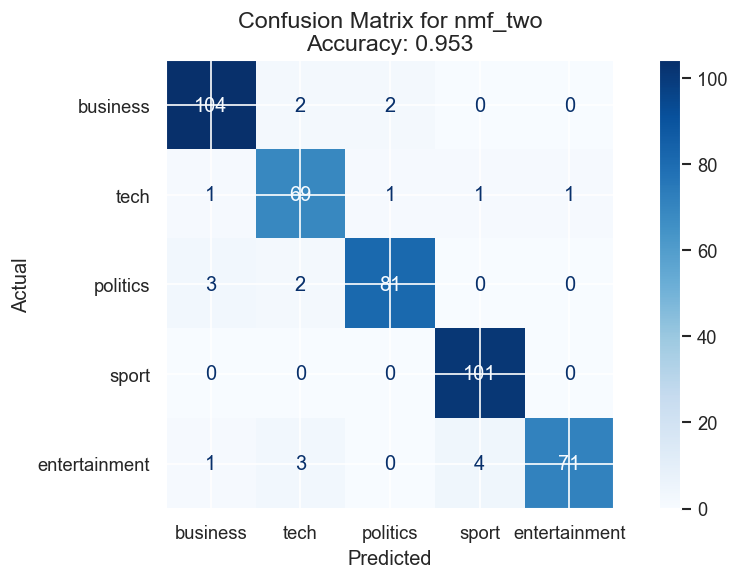


Misclassified articles per category, more than one example:

'politics' predicted as 'business' : 3 examples.

Article 894 (Category: politics):
gurkhas to help tsunami victims britain has offered to send a company of 120 gurkhas to assist with the tsunami relief effort in indonesia  downing street said.  the deployment would involve troops from the 2nd battalion royal gurkha rifles  based in brunei. discussions have begun with indonesia on 
--------------------------------------------------------------------------------

Article 962 (Category: politics):
hatfield executives go on trial engineering firm balfour beatty and five railway managers are to go on trial for manslaughter over the hatfield rail crash in 2000.  four people died when a section of rail broke and a high speed train derailed. balfour beatty s railway maintenance arm was in charge o
--------------------------------------------------------------------------------

Article 296 (Category: politics):
protesters plan airp

In [45]:
# Split into train/test using same indices as before
W_train = W[indices_train]
W_test = W[indices_test]

# Train a classifier using topic distributions as features
topic_classifier = LogisticRegression(random_state=SEED)
topic_classifier.fit(W_train, y_train)

y_pred_topics = topic_classifier.predict(W_test)

# Evaluate
accuracy_nmf_two = plot_confusion(y_test, y_pred_topics, name='nmf_two')